In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2022-01-07 10:06:27--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘perrin-freres-monthly-champagne.csv’

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2022-01-07 10:06:27 (36.4 MB/s) - ‘perrin-freres-monthly-champagne.csv’ saved [1598/1598]



In [3]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv', index_col='Month',
                 skipfooter=2, parse_dates=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [4]:
df.columns = ['Sales']
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [5]:
df['LogSales'] = np.log(df['Sales'])

In [6]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [7]:
# Make supervised dataset

series = df['LogSales'].to_numpy()

T = 12 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (93, 12) Y.shape (93,)


In [8]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [9]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.8682372095558999

In [10]:
lr.score(Xtest, Ytest)

0.9657520752272788

In [11]:
# Boolean index

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False

In [12]:
# 1-step forecast

df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

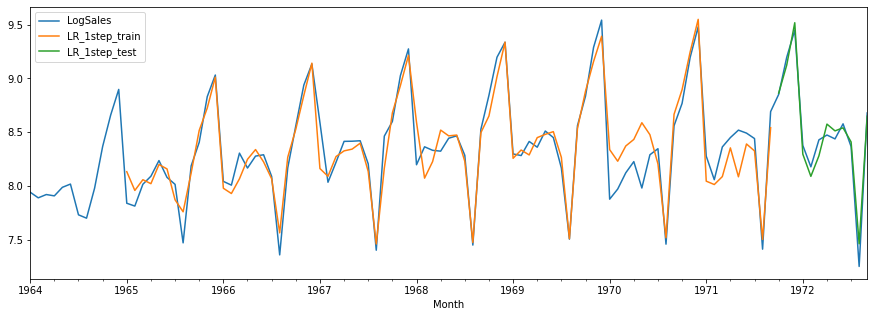

In [14]:
# Plot 1-step forecast

df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-step

In [15]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = lr.predict(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [16]:
# Save multi-step forecast to the dataframe

df.loc[test_idx, 'LR_multistep'] = multistep_predictions

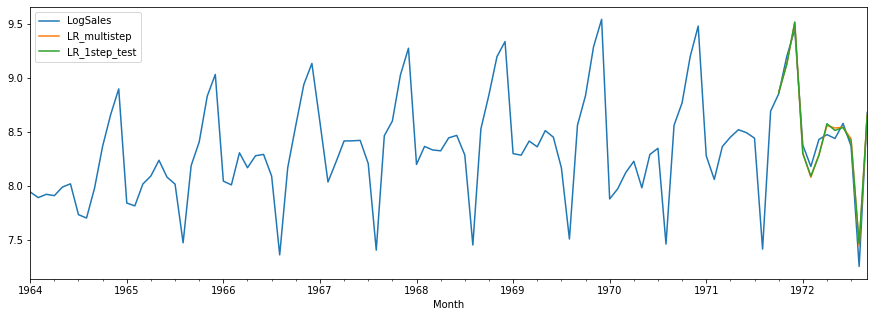

In [18]:
# Plot 1-step and multistep

df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-output

In [19]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (82, 12) Y.shape (82, 12)


In [20]:
# Split into train and test
# 

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [21]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8829262390390559

In [22]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.9595107879158425

In [23]:
# Save output to dataframe

df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

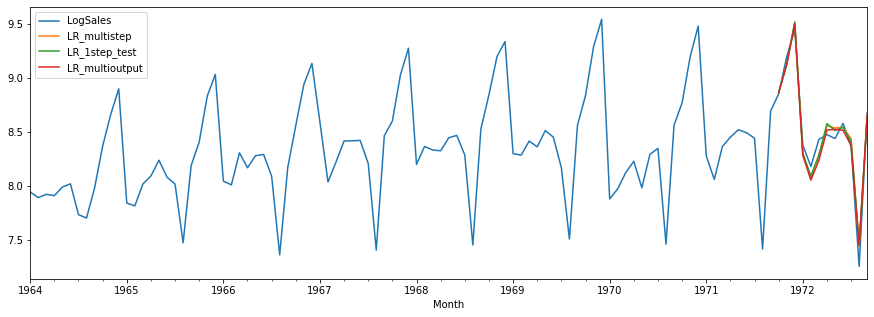

In [24]:
df[['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']].plot(figsize = (15, 5));

In [25]:
# Use different metric

# MAPE

mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.009607169373797731
Multi-output MAPE: 0.009727020853255877


### Test Other Models

In [28]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step Forecast:", name)

  # Store 1-step forecast

  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # Generate multi-step forecast

  multistep_predictions = []

  # First test input

  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # Update the predictions list

    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Store multi-step forecast

  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast

  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print('Test MAPE (multi-step):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']].plot(figsize = (15, 5));

One-step Forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


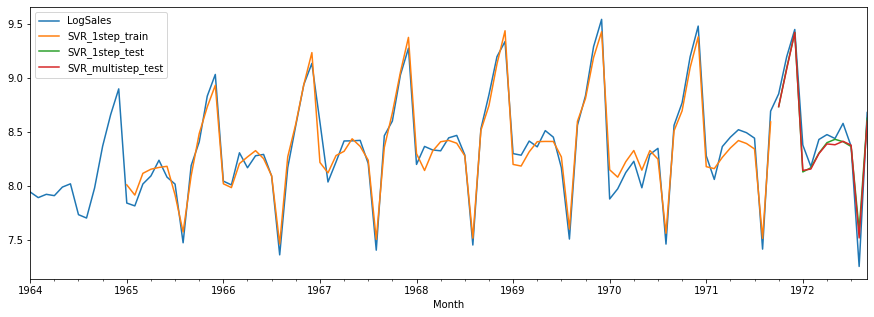

In [29]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step Forecast: RF
Test MAPE (multi-step): 0.010612888512812196


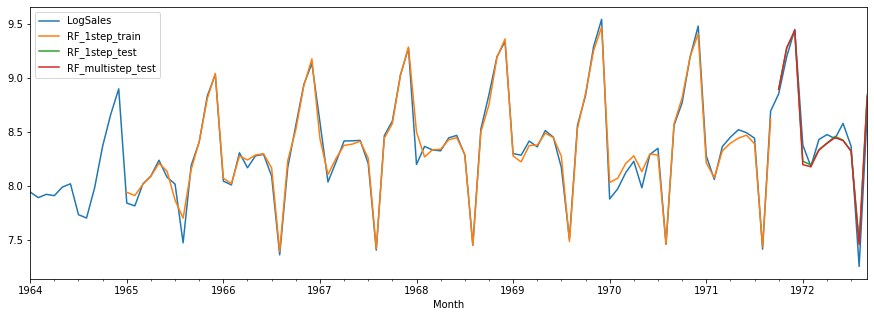

In [30]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

### Multi-Output

In [31]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # Store multioutput forecast to dataframe

  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  # MAPE of multioutput forecast

  mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print('Test MAPE (multioutput):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogSales', f'{name}_1step_train',
      f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']].plot(figsize = (15, 5));

Test MAPE (multioutput): 0.019318464095412807


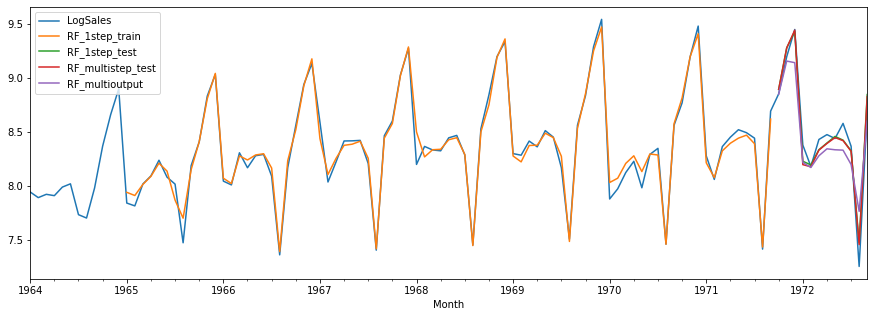

In [32]:
multi_output_forecast(RandomForestRegressor(), "RF")